In [1]:
from sklearn.datasets import fetch_openml

from imblearn.datasets import make_imbalance
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.model_selection import cross_validate, RandomizedSearchCV

import pandas as pd

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, OrdinalEncoder

from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, f_classif

from tempfile import mkdtemp
cachedir = mkdtemp()

from sklearn.metrics import classification_report, make_scorer, balanced_accuracy_score, accuracy_score, precision_score, recall_score, roc_auc_score

import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_context("poster")


/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
def load_data():
    df, y = fetch_openml("adult", version=2, as_frame=True, return_X_y=True)
    df = df.drop(columns=["fnlwgt", "education-num"])
    return df, y

def make_imbalanced(X,y,ratio=30):
    classes_count = y.value_counts()
    df_res, y_res = make_imbalance(
        X,
        y,
        sampling_strategy={classes_count.idxmin(): classes_count.max() // ratio},
    )
    y_res.value_counts()

    return df_res, y_res

In [3]:
X, y = load_data()
X, y = make_imbalanced(X, y)
y = y.replace(['<=50K','>50K'],[0,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,18.0,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States
3,34.0,Private,10th,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States
4,29.0,NaN,HS-grad,Never-married,NaN,Unmarried,Black,Male,0.0,0.0,40.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
38388,52.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States
38389,56.0,Private,Some-college,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,54.0,United-States
38390,64.0,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,50.0,United-States
38391,42.0,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,0.0,0.0,40.0,United-States


In [5]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'balanced_accuracy': make_scorer(balanced_accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'auc': make_scorer(roc_auc_score),}

def make_simple_prepro():

    num_pipe = make_pipeline(
        StandardScaler(),
        PCA(),
        KBinsDiscretizer()
    )
    cat_pipe = make_pipeline(
        OneHotEncoder(handle_unknown="ignore"),
    )

    preprocessor = make_column_transformer(
        (num_pipe, selector(dtype_include="number")),
        (cat_pipe, selector(dtype_include="category")),
        n_jobs=-1,
    )
    return preprocessor

def make_pipe(preprocessor):
    return imbPipeline([
        ('preprocessor', preprocessor),
        ('selector', 'passthrough' ),
        ('balancer', SMOTEENN()),
        ('model', 'passthrough'),
    ], memory=cachedir)


preprocessor = make_simple_prepro()
pipeline = make_pipe(preprocessor)

def lr_fitter(pipe=pipeline,scoring=scoring):

    parameters = [
    {
        'model': [LogisticRegression(max_iter=1000,class_weight='balanced')],
        'selector':[SelectKBest(f_classif)],
        'preprocessor__pipeline-1__pca__n_components': [4],
        'preprocessor__pipeline-1__kbinsdiscretizer__n_bins': [4],
        'preprocessor__pipeline-1__kbinsdiscretizer__strategy': ['uniform'],
        'preprocessor__pipeline-1__kbinsdiscretizer__encode': ['onehot'],
        'selector__k' : [40],

        'model__penalty' : ['l2'],
        'model__C' : [1],
        'model__l1_ratio': [0.1],

        'balancer__sampling_strategy': ['all']

        }
    ]
    
    grid_search = RandomizedSearchCV(
        pipeline,
        param_distributions=parameters,
        scoring=scoring,
        n_jobs=-1,
        verbose=True,
        n_iter = 1,
        refit='auc',
        cv=3
    )

    grid_search.fit(X_train, y_train)
    
    return grid_search

In [6]:
model_lr = lr_fitter()

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are 

In [14]:
display(abs(model_lr.best_score_))
display(model_lr.best_params_)
#display(grid_search.feature_names_in_)
#display(grid_search.cv_results_)
best_lr = model_lr.best_estimator_

0.7616257347799285

{'selector__k': 40,
 'selector': SelectKBest(k=40),
 'preprocessor__pipeline-1__pca__n_components': 4,
 'preprocessor__pipeline-1__kbinsdiscretizer__strategy': 'uniform',
 'preprocessor__pipeline-1__kbinsdiscretizer__n_bins': 4,
 'preprocessor__pipeline-1__kbinsdiscretizer__encode': 'onehot',
 'model__penalty': 'l2',
 'model__l1_ratio': 0.1,
 'model__C': 1,
 'model': LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.1, max_iter=1000),
 'balancer__sampling_strategy': 'all'}

/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.84      0.91      9289
           1       0.12      0.67      0.21       310

    accuracy                           0.83      9599
   macro avg       0.55      0.75      0.56      9599
weighted avg       0.96      0.83      0.88      9599



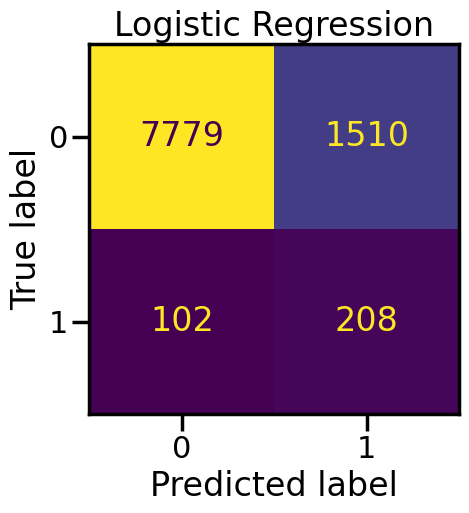

In [9]:
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, colorbar=False)
_ = disp.ax_.set_title("Logistic Regression")

In [10]:
def rf_fitter(pipe=pipeline,scoring=scoring):

    parameters = [
    {
        'model': [RandomForestClassifier()],
        'selector':[SelectKBest(f_classif)],
        'preprocessor__pipeline-1__pca__n_components': [4],
        'preprocessor__pipeline-1__kbinsdiscretizer__n_bins': [4],
        'preprocessor__pipeline-1__kbinsdiscretizer__strategy': ['uniform'],
        'preprocessor__pipeline-1__kbinsdiscretizer__encode': ['onehot'],
        'selector__k' : [20,30,35,40,45],

        'model__n_estimators' : [5,10,15,20,50,100],
        'model__class_weight' : ['balanced', 'balanced_subsample'],
        'model__bootstrap': [True,False],
        'model__oob_score': [True,False],

        'balancer__sampling_strategy': ['all']

        }
    ]
    
    grid_search = RandomizedSearchCV(
        pipeline,
        param_distributions=parameters,
        scoring=scoring,
        n_jobs=-1,
        verbose=True,
        n_iter = 120,
        refit='auc',
        cv=3
    )

    grid_search.fit(X_train, y_train)
    
    return grid_search

In [11]:
model_rf=rf_fitter()

Fitting 3 folds for each of 120 candidates, totalling 360 fits


/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are 

/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarnin

/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/extra/crypto/ML/crypto/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarnin

In [13]:
display(abs(model_rf.best_score_))
display(model_rf.best_params_)
#display(grid_search.feature_names_in_)
#display(grid_search.cv_results_)
best_rf = model_rf.best_estimator_

0.6522969117016723

{'selector__k': 40,
 'selector': SelectKBest(k=40),
 'preprocessor__pipeline-1__pca__n_components': 4,
 'preprocessor__pipeline-1__kbinsdiscretizer__strategy': 'uniform',
 'preprocessor__pipeline-1__kbinsdiscretizer__n_bins': 4,
 'preprocessor__pipeline-1__kbinsdiscretizer__encode': 'onehot',
 'model__oob_score': False,
 'model__n_estimators': 5,
 'model__class_weight': 'balanced_subsample',
 'model__bootstrap': False,
 'model': RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                        n_estimators=5),
 'balancer__sampling_strategy': 'all'}

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      9289
           1       0.18      0.31      0.23       310

    accuracy                           0.93      9599
   macro avg       0.58      0.63      0.60      9599
weighted avg       0.95      0.93      0.94      9599



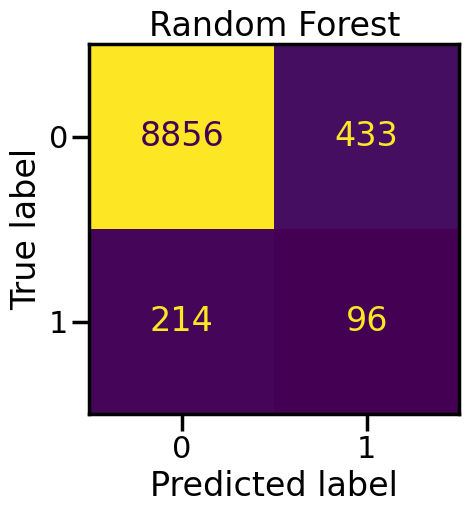

In [15]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, colorbar=False)
_ = disp.ax_.set_title("Random Forest")

In [ ]:
num_pipe = SimpleImputer(strategy="mean", add_indicator=True)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)

preprocessor_tree = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

rf_clf = make_pipeline(
    preprocessor_tree, (random_state=42, n_jobs=2)
)

In [ ]:
index += ["Random forest"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

In [ ]:
lr_clf.set_params(logisticregression__class_weight="balanced")

index += ["Logistic regression with balanced class weights"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

In [ ]:
rf_clf.set_params(randomforestclassifier__class_weight="balanced")

index += ["Random forest with balanced class weights"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

In [ ]:


lr_clf = make_pipeline_with_sampler(
    preprocessor_linear,
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000),
)

In [ ]:
index += ["Under-sampling + Logistic regression"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

In [ ]:
rf_clf = make_pipeline_with_sampler(
    preprocessor_tree,
    RandomUnderSampler(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2),
)

In [ ]:
index += ["Under-sampling + Random forest"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores


In [ ]:

rf_clf = make_pipeline(
    preprocessor_tree,
    BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
)

In [ ]:
index += ["Balanced random forest"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

In [ ]:


bag_clf = make_pipeline(
    preprocessor_tree,
    BalancedBaggingClassifier(
        estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10,
        random_state=42,
        n_jobs=-1,
    ),
)

index += ["Balanced bag of histogram gradient boosting"]
cv_result = cross_validate(bag_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores
